In [202]:
import os
import sys
import json
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.engine import road_model
import random

sys.path.insert(0, r'../../../osm-api/') # Add path to quetzal
from sklearn.cluster import KMeans
from shapely.geometry import Point
import numpy as np

In [224]:
road_folder = '../../inputs/road/'
demand_folder = '../../inputs/'
zones_folder = '../../inputs/zones/'

In [225]:
nodes = gpd.read_file(road_folder + 'road_nodes.geojson')

In [226]:
def create_zones_from_nodes(nodes,num_zones=200):
    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)
    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)
    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')
    cluster.fit(nodes[['x','y']].values)
    geom = [Point(val) for val in cluster.cluster_centers_]
    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)
    zones.index = 'zone_' + zones.index.astype(str)
    return zones

In [227]:
zones = create_zones_from_nodes(nodes)
zones.crs=4326

<Axes: >

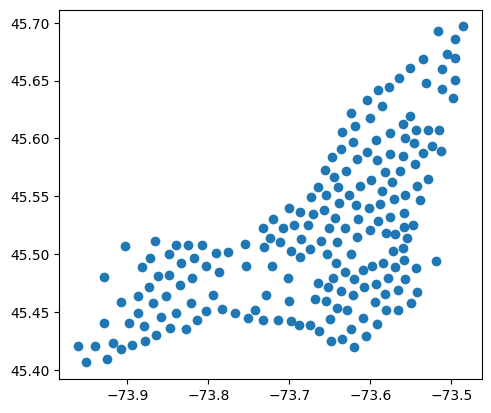

In [228]:
zones.plot()

In [229]:
#zones.to_file(demand_folder + 'centroids.geojson',driver='GeoJSON')

# create a demand

In [230]:
zones_list = zones.index
odv=[]
for i in range(1000):
    o = zones_list[random.randint(0,len(zones)-1)]
    d = zones_list[random.randint(0,len(zones)-1)]
    v = random.randint(0,100)
    odv.append({'origin':o,'destination':d,'volume':v})
demand = pd.DataFrame(odv)
demand.index.name='index'

In [231]:
#demand.to_csv(demand_folder + 'demand.csv')

# export demand as json for quenedi

In [232]:
# Group the DataFrame by "origin" and "destination", and then convert to JSON
grouped = demand.groupby(["origin", "destination"])["volume"].sum().reset_index()
json_data = {}
for _, row in grouped.iterrows():
    origin = row["origin"]
    destination = row["destination"]
    volume = row["volume"]
    if origin not in json_data:
        json_data[origin] = {}
    json_data[origin][destination] = volume

    
#with open(demand_folder + 'zones.json', 'w') as json_file:
    #json.dump({'volume':json_data},json_file)

# voronoi for zone instead of centroid

In [233]:
from syspy.spatial.spatial import voronoi_diagram_dataframes, voronoi_diagram

In [234]:
voronoi = voronoi_diagram_dataframes(zones['geometry'])

/home/boivin/.pyenv/versions/quetzal_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [235]:
voronoi = gpd.GeoDataFrame(voronoi[0],crs=4326)

In [236]:
hull = gpd.read_file(zones_folder+'montreal.geojson').to_crs(4326)
voronoi = voronoi.clip(hull)

<Axes: >

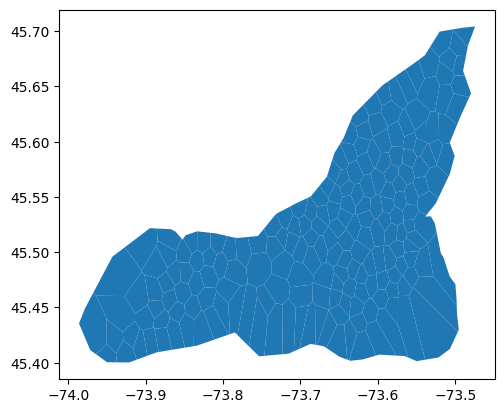

In [237]:
voronoi.plot()

In [238]:
#voronoi.to_file(demand_folder + 'zones.geojson',driver='GeoJSON')

In [239]:
#from syspy.spatial.spatial import add_geometry_coordinates

# create random od test

In [240]:
def noise():
    return np.random.normal(0,0.01,1)[0]


In [241]:
od_test=[]
for k in range(10):
    i = random.randint(0,len(nodes)-1)
    j = random.randint(0,len(nodes)-1)
    xo = nodes.iloc[i]['x'] + noise()
    yo = nodes.iloc[i]['y'] + noise()
    xd = nodes.iloc[j]['x'] + noise()
    yd = nodes.iloc[j]['y'] + noise()
    od_test.append({'name':'OD_'+str(k),'xo':xo,'yo':yo,'xd':xd,'yd':yd})
od_test.append({'name':'OD_SF','xo':-73.58439728314566,'yo':45.53768657307723,'xd':-73.570456710056,'yd':45.498204387032764})
od_test.append({'name':'OD_SB','xo':-73.54425385513646,'yo':45.5525182030598,'xd':-73.570456710056,'yd':45.498204387032764})
od_test.append({'name':'OD_SB2','xo':-73.54425385513646,'yo':45.5525182030598,'xd':-73.61775131909698,'yd':45.53536314933729})

od_test = pd.DataFrame(od_test)
od_test.index.name='index'

In [242]:
od_test

,name,xo,yo,xd,yd
index,,,,,
0,OD_0,-73.646573,45.564648,-73.656808,45.433709
1,OD_1,-73.637414,45.517892,-73.576498,45.557534
2,OD_2,-73.614244,45.511957,-73.861912,45.443598
3,OD_3,-73.698046,45.537066,-73.599178,45.551437
4,OD_4,-73.824327,45.441889,-73.616070,45.523945
5,OD_5,-73.560779,45.480897,-73.550398,45.564241
6,OD_6,-73.586174,45.597352,-73.578835,45.532771
7,OD_7,-73.671690,45.481585,-73.520542,45.616217
8,OD_8,-73.606189,45.602911,-73.560594,45.607795


In [245]:
od_test.to_csv(demand_folder + 'od_test.csv')


# create demand as xo,yo,xd,yd

In [246]:
new_demand=[]
for k in range(10000):
    i = random.randint(0,len(nodes)-1)
    j = random.randint(0,len(nodes)-1)
    xo = nodes.iloc[i]['x']
    yo = nodes.iloc[i]['y'] 
    xd = nodes.iloc[j]['x'] 
    yd = nodes.iloc[j]['y'] 
    new_demand.append({'xo':xo,'yo':yo,'xd':xd,'yd':yd,'volume':random.randint(0,100)})

new_demand = pd.DataFrame(new_demand)
new_demand.index.name='index'

In [247]:
demand = new_demand

In [248]:
demand.to_csv(demand_folder+'demand.csv')

In [257]:
x_lim = [-71.331424, -71.1962195]
y_lim = [46.7818178, 46.825208]

In [262]:
new_demand=[]
for k in range(10000):
    xo = random.randint(np.round(x_lim[0]*1e6),np.round(x_lim[1]*1e6))/1e6
    yo = random.randint(np.round(y_lim[0]*1e6),np.round(y_lim[1]*1e6))/1e6
    xd = random.randint(np.round(x_lim[0]*1e6),np.round(x_lim[1]*1e6))/1e6
    yd = random.randint(np.round(y_lim[0]*1e6),np.round(y_lim[1]*1e6))/1e6
    new_demand.append({'xo':xo,'yo':yo,'xd':xd,'yd':yd,'volume':random.randint(0,100)})

new_demand = pd.DataFrame(new_demand)
new_demand.index.name='index'

In [267]:
new_demand.to_csv('../../test/demand_qc.csv')

In [268]:
od_test=[]
for k in range(10):
    xo = random.randint(np.round(x_lim[0]*1e6),np.round(x_lim[1]*1e6))/1e6
    yo = random.randint(np.round(y_lim[0]*1e6),np.round(y_lim[1]*1e6))/1e6
    xd = random.randint(np.round(x_lim[0]*1e6),np.round(x_lim[1]*1e6))/1e6
    yd = random.randint(np.round(y_lim[0]*1e6),np.round(y_lim[1]*1e6))/1e6
    od_test.append({'name':'OD_'+str(k),'xo':xo,'yo':yo,'xd':xd,'yd':yd})

od_test = pd.DataFrame(od_test)
od_test.index.name='index'

In [269]:
od_test.to_csv('../../test/od_test.csv')


In [270]:
od_test

,name,xo,yo,xd,yd
index,,,,,
0,OD_0,-71.329471,46.813762,-71.226580,46.802236
1,OD_1,-71.257463,46.781834,-71.275064,46.795452
2,OD_2,-71.227036,46.811419,-71.202701,46.791298
3,OD_3,-71.305008,46.797389,-71.288863,46.817872
4,OD_4,-71.268833,46.804565,-71.253284,46.798521
5,OD_5,-71.224267,46.807805,-71.227449,46.796754
6,OD_6,-71.228827,46.824617,-71.300985,46.796591
7,OD_7,-71.315340,46.824012,-71.211729,46.803660
8,OD_8,-71.213989,46.798891,-71.266754,46.803542


In [272]:
new_demand

,xo,yo,xd,yd,volume
index,,,,,
0,-71.229626,46.785718,-71.238669,46.813079,23
1,-71.267950,46.817031,-71.316601,46.794271,98
2,-71.217242,46.788997,-71.242299,46.799868,18
3,-71.289217,46.804150,-71.250750,46.783980,14
4,-71.300844,46.814425,-71.285264,46.782266,68
...,...,...,...,...,...
9995,-71.243163,46.797527,-71.222653,46.822845,79
9996,-71.302755,46.789150,-71.271778,46.796505,54
9997,-71.237368,46.784497,-71.224168,46.799185,38
